Basic usage of SAM, taken from: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

Before running, make sure you followed the readme. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Utility functions

### Functions for display purposes, showing masks, points or boxes

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 255/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

### Use sam predictor to get masks

In [3]:
def get_masks_from_image(image, predictor):
    # naïve: return mask from center point
    predictor.set_image(image)
    cx, cy = image.shape[1]//2, image.shape[0]//2
    input_point = np.array([[cx, cy]])
    input_label = np.array([1])

    #Show image with point
    # plt.figure(figsize=(10,10))
    # plt.imshow(image)
    # show_points(input_point, input_label, plt.gca())
    # plt.show()
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    #Show masks
    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     plt.figure(figsize=(10,10))
    #     plt.imshow(image)
    #     show_mask(mask, plt.gca())
    #     show_points(input_point, input_label, plt.gca())
    #     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    #     plt.axis('off')
    #     plt.show()  

    return masks


### Get biggest mask in desired style

In: 
* masks: masks generated by sam
* image: opencv image
* output_style: mask, black or white, depending on target model
* mask_type: wide or tight, depending on preference

out: 
numpy image of mask

In [11]:
def get_biggest_mask(masks, image, output_style="mask", mask_style="tight"):
    mask = masks[-1]
    if mask_style == "wide":
        mask = mask.astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100,100))
        dilate = cv2.dilate(mask, kernel, iterations=1)
        mask = np.array(dilate, dtype=bool)

    match output_style:
        case "mask":
            return mask
    
        case "black":
            h, w = mask.shape[-2:]
            masked_image = image * ~mask.reshape(h, w, 1)
            return masked_image
        
        case "white":
            h, w = mask.shape[-2:]
            white_image = np.ones_like(image) * 255
            masked_image = np.where(mask.reshape(h, w, 1), white_image, image)
            return masked_image
        
        case "transparent_white":
            h, w = mask.shape[-2:]
            white_image = np.ones((h,w,4),dtype=np.uint8) * 255
            transparent_image = np.zeros((h,w,4),dtype=np.uint8)
            #transparent_image[:, :, 3] = 0 # Set the alpha channel to 0 (fully transparent) for all pixels
            masked_image = np.where(mask.reshape(h, w, 1), white_image, transparent_image)
            return masked_image

### Example usage

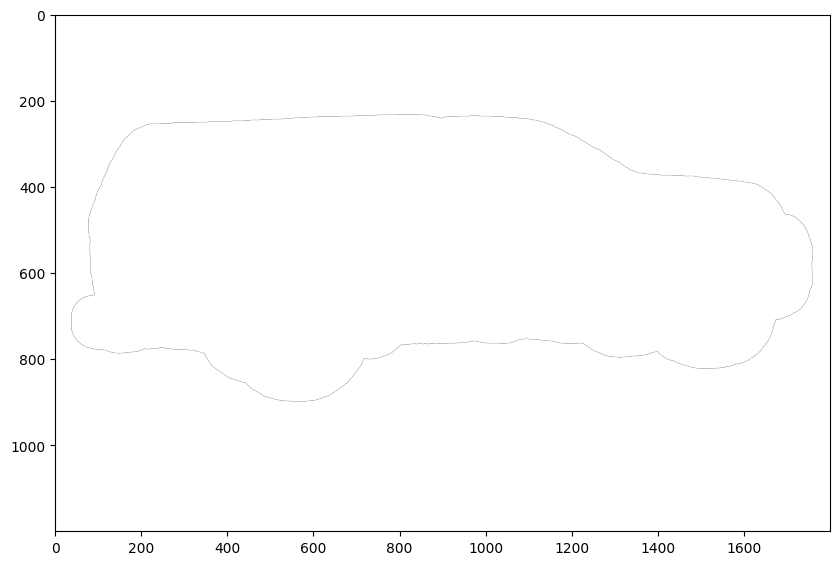

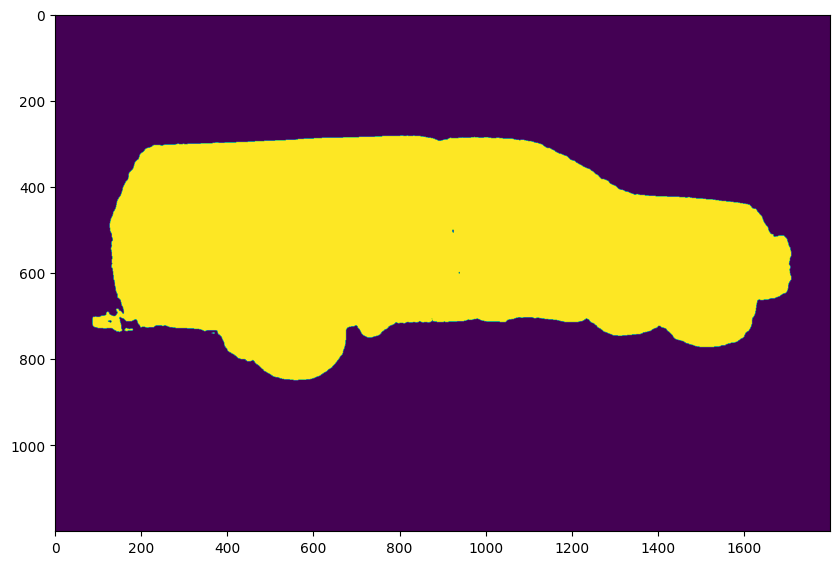

In [12]:

from segment_anything import SamPredictor, sam_model_registry

sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
print(predictor)
image = cv2.imread("images/inputs/truck_input.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#masks = get_masks_from_image(image, predictor)
wide_mask = get_biggest_mask(masks, image, output_style="transparent_white", mask_style="wide")
plt.figure(figsize=(10,10))
plt.imshow(wide_mask)#[:,:,:2])
plt.show()

tight_mask = get_biggest_mask(masks, image, output_style="mask", mask_style="tight")
plt.figure(figsize=(10,10))
plt.imshow(tight_mask)
plt.show()

### All in one function to be called from other files

In [13]:
def sam_generate_mask(image_path, mask_style="wide", output_style="transparent_white",save_as_file=False,mask_path=""):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #predictor must be declared?
    masks = get_masks_from_image(image, predictor)
    mask = get_biggest_mask(masks, image, output_style=output_style, mask_style=mask_style)
    if save_as_file and mask_path!="":
        cv2.imwrite(mask_path,mask)
    return mask



### Turn jupyter notebook into script
if you want to use it in other files
```
from sam_generate_masks import sam_generate_mask
```

In [14]:
!jupyter nbconvert --to script sam_generate_masks.ipynb

[NbConvertApp] Converting notebook sam_generate_masks.ipynb to script
[NbConvertApp] Writing 5243 bytes to sam_generate_masks.py
